## In this notebook we aim to provide insight into on what base our model made a prediction
We will utilize the Lime package but then slightly modified.
https://github.com/marcotcr/lime/tree/master/lime

In [1]:
from skimage.segmentation import mark_boundaries
from lime import lime_image
import re
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import cv2
import numpy as np

/Users/rubensikkes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


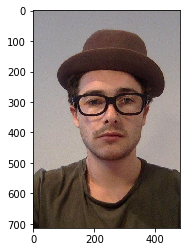

In [2]:
# Example image
image_path = "images/ruben.jpg"

# Loading our image and making sure its in the right color coding
im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [3]:
# Initializing
explainer = lime_image.LimeImageExplainer(feature_selection= "none")

In [4]:
# For Lime we need a prediction function which will be used as evaluation when we flip pixels.
def predict_fn(images):
    # Read in the image_data
    all_predictions = []

    # Unpersists graph from file
    with tf.gfile.FastGFile("glasses/retrained_graph.pb", 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

    with tf.Session() as sess:
        # Feed the image_data as input to the graph and get first prediction
        softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')

        for image_arr in images:
            #
            #cv2.imwrite("tmp.jpeg", image_arr)
            cv2.imwrite("tmp.jpeg", cv2.cvtColor(image_arr, cv2.COLOR_RGB2BGR))
            image_data = tf.gfile.FastGFile('tmp.jpeg', 'rb').read()

            # Loads label file, strips off carriage return
            label_lines = [line.rstrip() for line 
                               in tf.gfile.GFile("glasses/labels.txt")]


            predictions = sess.run(softmax_tensor, \
                 {'DecodeJpeg/contents:0': image_data})

            # Sort to show labels of first prediction in order of confidence
            top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]
            #print("predictions:", predictions)
            all_predictions.append(predictions[0,:])
    return np.array(all_predictions)

In [5]:
# What do we predict:
model_prediction = predict_fn([im])
# Which index has highest score
max_index = model_prediction.argmax()

f = open("glasses/labels.txt" , "r")
text = f.read().splitlines()
f.close()

print("Predicted scores:", model_prediction)
print("So we predict {} with a confidence of {:.2f}".format(text[max_index],model_prediction[0][max_index]))
#array([[0.46800762, 0.5321518 ]], dtype=float32)

Predicted scores: [[0.7456548  0.25325388]]
So we predict glasses with a confidence of 0.75


In [6]:
import time
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(im, predict_fn, hide_color=0, num_samples=3000, batch_size=3000)
print(time.time() - tmp)

[[7.4565482e-01 2.5325388e-01]
 [8.8627511e-01 1.1415240e-01]
 [9.9912804e-01 8.7157654e-04]
 ...
 [9.6464312e-01 3.6059737e-02]
 [9.4087785e-01 5.9293680e-02]
 [7.8834480e-01 2.1017115e-01]]
1
[[7.4565482e-01 2.5325388e-01]
 [8.8627511e-01 1.1415240e-01]
 [9.9912804e-01 8.7157654e-04]
 ...
 [9.6464312e-01 3.6059737e-02]
 [9.4087785e-01 5.9293680e-02]
 [7.8834480e-01 2.1017115e-01]]
0
7630.097720146179


In [7]:
# Creating a mask which will be put on top of our original mask.
temp, mask = explanation.get_image_and_mask(max_index, positive_only=False, num_features=10, hide_rest=False, min_weight=0.01)

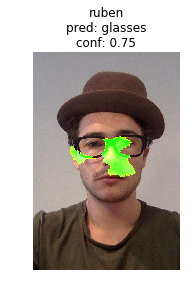

In [8]:
plt.imshow(mark_boundaries(temp , mask))
plt.title('{}\npred: {}\nconf: {:.2f}'.format(re.split('[./]',image_path)[1],text[max_index], model_prediction[0][max_index]))
plt.axis('off')
plt.show()

Indicating that our model is mainly looking at the area around glasses and in particular the nose to form a prediction. 